# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt 
from tqdm import tqdm

# Importing & loading my personal favorite standard plot style settings
sys.path.append('../scripts/utilities')
from standard_style import standard_style
standard_style()

# Definieer data locaties
input_path = os.path.join('..', 'data', 'input')
output_path = os.path.join('..', 'data', 'output')

## Utilities

In [2]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

def is_valid_date(date_str):
  """
  Checks if the given date string is a valid date format (YYYY-MM-DD)
  and handles February 29th for leap years.

  Args:
      date_str: The date string to validate.

  Returns:
      A pandas datetime object if the date is valid, None otherwise.
  """
  try:
    date = pd.to_datetime(date_str, format="%Y-%m-%d", errors="coerce")
    if not pd.isnull(date) and date.month == 2 and date.day == 29:
      # Check for leap year
      if date.year % 4 == 0 and (date.year % 100 != 0 or date.year % 400 == 0):
        return date
      else:
        return None  # Not a leap year, so invalid 29th of February
    else:
      return date  # Valid date (not 29th of February)
  except ValueError:
    return None  # Invalid date format


## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

### Loading the data

In [3]:
# Loading data - of all csv-files in the input folder - in the dataframe

# declaring 2 empty list to store dataframes for each birthdate - one for the right birthdates and one for the wrong birthdates
dfs_right_list = []
dfs_wrong_list = []

# Looping through each file in the input folder, reading the csv files and adding the birthdate to the dataframe
for filename in tqdm(os.listdir(input_path)):
    if filename.endswith(".csv"):
        full_path = os.path.join((input_path), filename)
        with open(full_path, 'r') as f:
            df = pd.read_csv(full_path, sep=',')
            # Adding birthdate to each record - sourced from the filename and removing the .csv extension
            df['geboorte datum'] = filename.split(".csv")[0]
            # Check if the birthdate is valid
            if not pd.isna(is_valid_date(filename.split(".csv")[0])):
                dfs_right_list.append(df)
            else:
                df['why_wrong'] = "Invalid date"
                dfs_wrong_list.append(df)

# Concatenate both lists to one dataframe for each list
geboortes = pd.concat(dfs_right_list, ignore_index=True)
df_wrong = pd.concat(dfs_wrong_list, ignore_index=True)

# Inspect the dataframes
print(geboortes.head())
print(df_wrong.head())

100%|██████████| 366/366 [00:00<00:00, 1330.37it/s]

     gemeente   naam    geslacht verwachte datum geboorte datum
0       Ukkel  Clara  Vrouwelijk      09/08/2019      2019-8-30
1  Brasschaat  Joeri   Mannelijk      08/26/2019      2019-8-30
2       Waver   Axel   Mannelijk      09/14/2019      2019-8-30
3     Seraing  Osman   Mannelijk      08/26/2019      2019-8-30
4    Aywaille  Wendy  Vrouwelijk      09/12/2019      2019-8-30
              gemeente        naam    geslacht verwachte datum geboorte datum  \
0              Kruisem     Patrick   Mannelijk      02/27/2019      2019-2-29   
1  Montigny-le-Tilleul       Sarah  Vrouwelijk      03/11/2019      2019-2-29   
2           Diepenbeek  Valentinus   Mannelijk      03/02/2019      2019-2-29   
3  Sint-Jans-Molenbeek          El   Mannelijk      02/27/2019      2019-2-29   
4             Overijse    Apolline  Vrouwelijk      03/03/2019      2019-2-29   

      why_wrong  
0  Invalid date  
1  Invalid date  
2  Invalid date  
3  Invalid date  
4  Invalid date  


### Cleaning & preprocessing the data

In [4]:
# Inspect the loaded dataframe
geboortes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116850 entries, 0 to 116849
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   gemeente         116850 non-null  object
 1   naam             116850 non-null  object
 2   geslacht         116850 non-null  object
 3   verwachte datum  116850 non-null  object
 4   geboorte datum   116850 non-null  object
dtypes: object(5)
memory usage: 4.5+ MB


In [5]:
# Inspect the loaded dataframe
df_wrong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gemeente         73 non-null     object
 1   naam             73 non-null     object
 2   geslacht         73 non-null     object
 3   verwachte datum  73 non-null     object
 4   geboorte datum   73 non-null     object
 5   why_wrong        73 non-null     object
dtypes: object(6)
memory usage: 3.6+ KB


In [6]:
# Convert datatypes
# Convert columns containing dates to datetime
geboortes['geboorte datum'] = pd.to_datetime(geboortes['geboorte datum'])	
geboortes['verwachte datum'] = pd.to_datetime(geboortes['verwachte datum'])	

# Convert columns containing categorical data to category
geboortes['geslacht'] = geboortes['geslacht'].astype('category')

# Add day of year to dataframe
if 'dag van het jaar' not in geboortes.columns:
	geboortes['dag van het jaar'] = geboortes['geboorte datum'].dt.dayofyear

In [7]:
# Inspect the converted dataframe
geboortes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116850 entries, 0 to 116849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   gemeente          116850 non-null  object        
 1   naam              116850 non-null  object        
 2   geslacht          116850 non-null  category      
 3   verwachte datum   116850 non-null  datetime64[ns]
 4   geboorte datum    116850 non-null  datetime64[ns]
 5   dag van het jaar  116850 non-null  int32         
dtypes: category(1), datetime64[ns](2), int32(1), object(2)
memory usage: 4.1+ MB


## Stap 2: Dagelijks aantal geboortes bekijken
#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

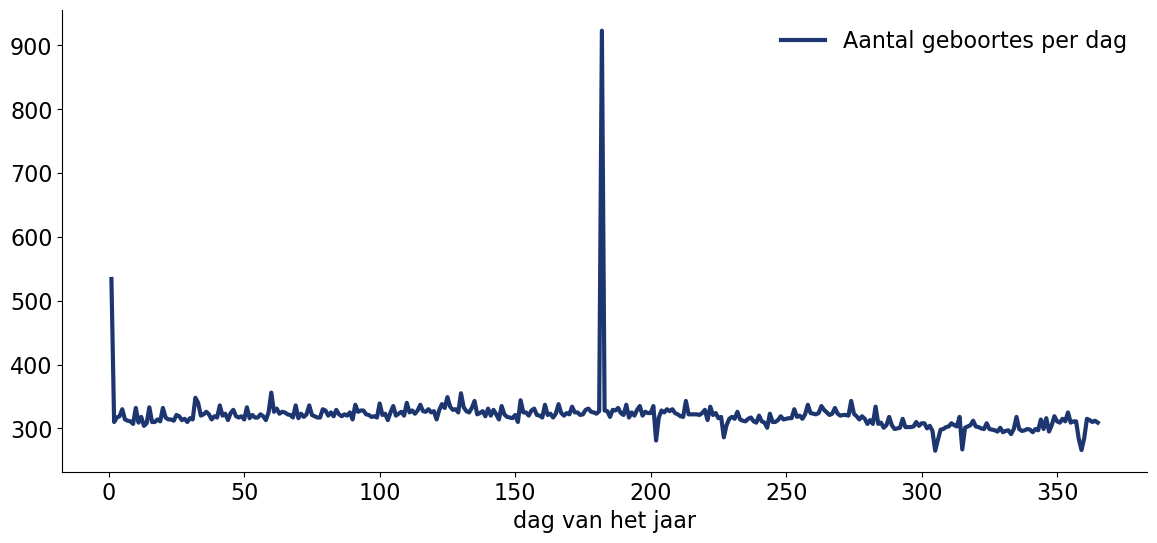

In [8]:
geboortes_per_dag = geboortes.groupby('dag van het jaar').size()
geboortes_per_dag.plot()
plt.legend(['Aantal geboortes per dag'])
plt.show()

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

In [9]:
# Calculating the mean
print("Mean:",geboortes['geboorte datum'].value_counts().mean())

# Calculating the threshold
print("Threshold:", geboortes['geboorte datum'].value_counts().mean()*0.5)

Mean: 320.13698630136986
Threshold: 160.06849315068493


In [10]:
# Quick visual inspection of the data to see if there are any outliers
print(geboortes.groupby('geboorte datum')['geboorte datum'].count().sort_values(ascending=False).tail(10))
print(geboortes.groupby('geboorte datum')['geboorte datum'].count().sort_values(ascending=False).head(10))

geboorte datum
2019-11-26    294
2019-11-29    291
2019-08-15    286
2019-12-26    285
2019-12-24    283
2019-11-02    282
2019-07-21    281
2019-11-11    267
2019-12-25    266
2019-11-01    265
Name: geboorte datum, dtype: int64
geboorte datum
2019-07-01    923
2019-01-01    534
2019-03-01    356
2019-05-10    355
2019-05-05    349
2019-02-01    348
2019-06-01    344
2019-08-01    343
2019-10-01    343
2019-05-15    343
Name: geboorte datum, dtype: int64


In [11]:
# Calculate average birth count
avg_births = geboortes['geboorte datum'].value_counts().mean()

# Calculate 50% threshold
threshold = avg_births * 0.5

# Group by date and calculate birth counts
birth_counts = geboortes.groupby('geboorte datum')['geboorte datum'].count()

# Identify outliers in groupby object based on threshold
outlier_dates = birth_counts[(birth_counts - avg_births).abs() > threshold].index.tolist()

# Print outliers
print("Outlier dates:")
print(outlier_dates)

Outlier dates:
[Timestamp('2019-01-01 00:00:00'), Timestamp('2019-07-01 00:00:00')]


Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [12]:
# Filter outliers from 'geboortes'
outliers = geboortes[geboortes['geboorte datum'].isin(outlier_dates)].copy()

# Add reason for removal to outliers
outliers['why_wrong'] = 'Verkeerde datum: ' + outliers['geboorte datum'].dt.strftime('%Y-%m-%d')

# Append outliers to 'df_wrong' (assuming headers are compatible)
df_wrong = pd.concat([df_wrong, outliers], ignore_index=True)

# Remove outliers from 'geboortes'
geboortes = geboortes[~geboortes['geboorte datum'].isin(outlier_dates)]

# Update 'geboortes' with outliers removed
geboortes.reset_index(drop=True, inplace=True)  # Reset index after removal

# Print results
print("geboortes dataframe after outlier removal:")
print(geboortes.head(5))

print("\ndf_wrong dataframe containing outliers (including existing):")
print(df_wrong.head(5))

geboortes dataframe after outlier removal:
     gemeente   naam    geslacht verwachte datum geboorte datum  \
0       Ukkel  Clara  Vrouwelijk      2019-09-08     2019-08-30   
1  Brasschaat  Joeri   Mannelijk      2019-08-26     2019-08-30   
2       Waver   Axel   Mannelijk      2019-09-14     2019-08-30   
3     Seraing  Osman   Mannelijk      2019-08-26     2019-08-30   
4    Aywaille  Wendy  Vrouwelijk      2019-09-12     2019-08-30   

   dag van het jaar  
0               242  
1               242  
2               242  
3               242  
4               242  

df_wrong dataframe containing outliers (including existing):
              gemeente        naam    geslacht verwachte datum geboorte datum  \
0              Kruisem     Patrick   Mannelijk      02/27/2019      2019-2-29   
1  Montigny-le-Tilleul       Sarah  Vrouwelijk      03/11/2019      2019-2-29   
2           Diepenbeek  Valentinus   Mannelijk      03/02/2019      2019-2-29   
3  Sint-Jans-Molenbeek          El  

Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

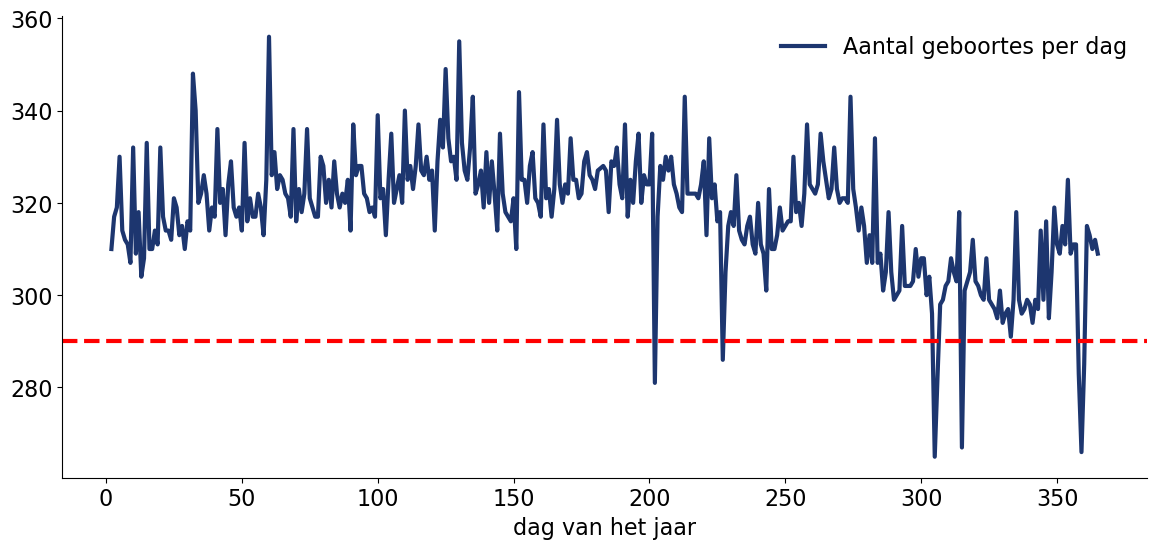

In [13]:
# Calculate average birth count
geboortes_per_dag = geboortes.groupby('dag van het jaar').size()
geboortes_per_dag.plot()
plt.legend(['Aantal geboortes per dag'])
plt.axhline(y=290, color='r', linestyle='--')
plt.show()

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 5 extreme uitschieters in de 2e helft van het jaar identificeren (in totaal 8 datums)?

In [14]:
# Creating a dataframe with the number of births per day and the requested columns
extreme_outliers = (geboortes[['geboorte datum', 'dag van het jaar']].value_counts()
                                                 .reset_index()
                                                 .rename(columns={'count':'Aantal geboortes'})
                                                 .sort_values(by='Aantal geboortes', ascending=True)) 

# Filtering the dataframe to only include days with less than 290 births
extreme_outliers = extreme_outliers[extreme_outliers['Aantal geboortes'] < 290]
extreme_outliers

,geboorte datum,dag van het jaar,Aantal geboortes
362,2019-11-01,305,265
361,2019-12-25,359,266
360,2019-11-11,315,267
359,2019-07-21,202,281
358,2019-11-02,306,282
357,2019-12-24,358,283
356,2019-12-26,360,285
355,2019-08-15,227,286


### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

In [15]:
# Removing outliers for bonus question
new_geboortes = geboortes[~geboortes['geboorte datum'].isin(extreme_outliers['geboorte datum'])]

In [26]:
# Make groupby object of birthdates with day of year and count the number of births
grouped_geboortes = (new_geboortes[['geboorte datum', 'dag van het jaar']].value_counts()
                                                 .reset_index()
                                                 .rename(columns={'count':'Aantal geboortes'})
                                                 .sort_values(by='dag van het jaar', ascending=True)) 

# define window_size for rolling average
window_size = 7

# Add a new column with the rolling average
grouped_geboortes['Rolling Average Births'] = grouped_geboortes['Aantal geboortes'].rolling(window=window_size, min_periods=1).mean().dropna()

In [17]:
# Inspecting the new dataframe
grouped_geboortes.head(10)

,geboorte datum,dag van het jaar,Aantal geboortes,Rolling Average Births
281,2019-01-02,2,310,310.000000
215,2019-01-03,3,317,313.500000
184,2019-01-04,4,319,315.333333
43,2019-01-05,5,330,319.000000
248,2019-01-06,6,314,318.000000
269,2019-01-07,7,312,317.000000
275,2019-01-08,8,311,316.142857
302,2019-01-09,9,307,315.714286
37,2019-01-10,10,332,317.857143
289,2019-01-11,11,309,316.428571


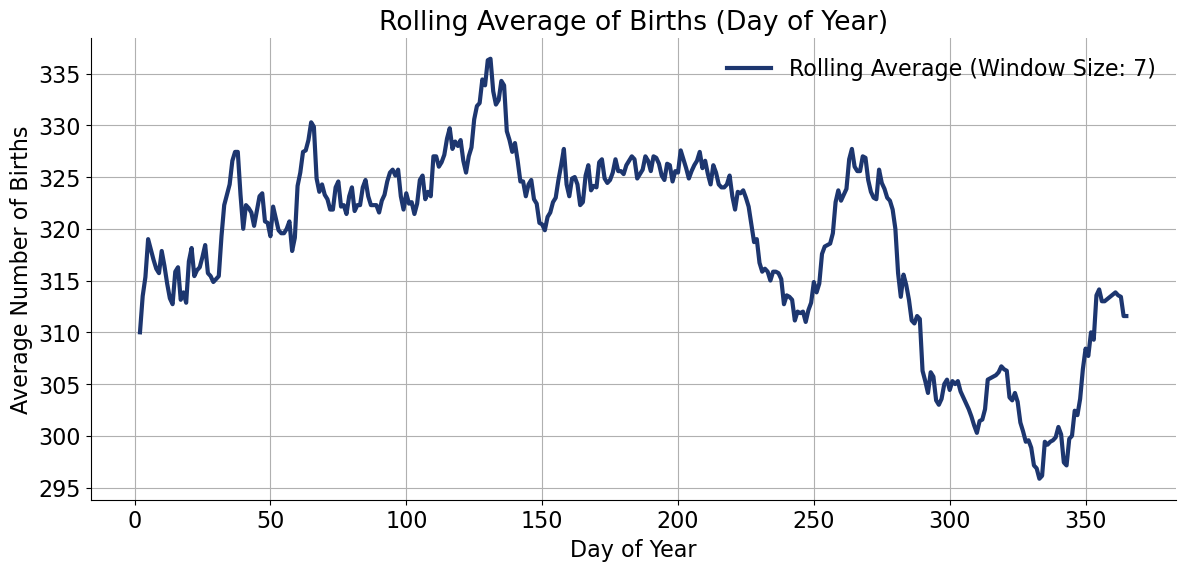

In [28]:
# Plot the data
plt.plot(grouped_geboortes['dag van het jaar'], grouped_geboortes['Rolling Average Births'].values, label='Rolling Average (Window Size: {})'.format(window_size))

# Set labels, title, and grid
plt.xlabel('Day of Year')
plt.ylabel('Average Number of Births')
plt.title('Rolling Average of Births (Day of Year)')
plt.grid(True)
plt.legend()

plt.show()


Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

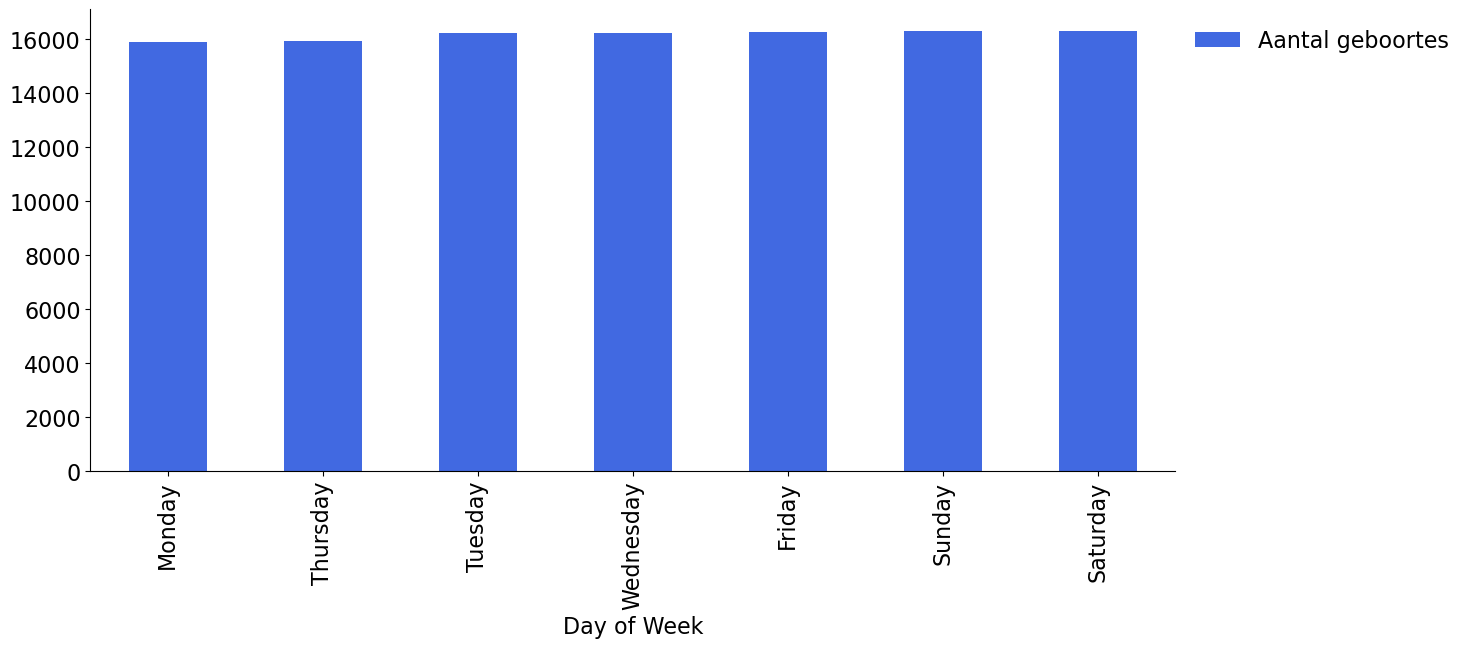

In [20]:
# Create a new column with the day of the week
if 'Day of Week' not in grouped_geboortes.columns:
    grouped_geboortes['Day of Week'] = grouped_geboortes['geboorte datum'].dt.day_name()
    
# Group by day of the week and calculate the average number of births
avg_births_per_day = grouped_geboortes.groupby('Day of Week')['Aantal geboortes'].sum().sort_values()

# Plot the data
avg_births_per_day.plot(kind='bar', color='royalblue')

# adding the legend
plt.legend(['Aantal geboortes'], bbox_to_anchor=(1, 1), 
          fancybox=True, shadow=True, facecolor='lightgrey')  # Adjust legend position if needed
plt.show()